<a href="https://colab.research.google.com/github/inf104776/sarcasmDetection/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sarkasmuserkennung

Im Bereich des Natural Language Processing (NLP) gibt es verschiedene Anwendungsziele. Viele beschäftigen sich mit dem Inhalt des Gesprochenen oder des Textes. Ein Fall, der nicht nur für den Computer eine Herausforderung bietet, sondern auch häufiger für den Menschen selbst, ist das Erkennen von Sarkasmus. 
Der [Duden](https://www.duden.de/rechtschreibung/Sarkasmus) beschreibt Sarkasmus als: "beißender, verletzender Spott, Hohn, der jemanden, etwas lächerlich machen will". Die Schwierigkeit ist meist, heruaszufinden, ob etwas ernst oder sarkastisch gemeint ist. Es benötigt eine genaue Analyse des Kontextes. Oftmals sind es auch nur Betonungn, die verraten, dass es sich um Sarkasmus handelte.
In direkter Verbindung dazu steht die Ironie, die immer das Gegenteil der getätigten Aussage bezeichent. Ironie ist nicht immer auch sarkastisch, kann aber im Zuge dessen verwendet werden.  

Textklassifizierung

## Projektbeschreibung

In diesem Projekt soll versucht werden mittels künstlicher Intelligenz und Methoden des Text-Mining Sarkasmus zu erkennen. Dafür wurde ein Datansatz ausgesucht, der aus Überschriften von Onlineartikeln besteht, welche aus zwei unterschiedlichen Quellen stammt. Die eine ist eine Satire-Seite ("The Onion"), die andere ist eine seriöse Pressestelle ("The Huffington Post").  

# Datenbeschaffung


Die Daten kommen aus [Kaggle](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset.json) und werden im Folgenden eingelesen. Ein Datensatz besteht aus drei Komponenten: die zu klassifizierende Überschrift, einem Label und einem Link zu dem entsprechenden Artikel. Das Label gibt an, ob ein Artikel sarkastisch ist (1) oder nicht (0).

## Web-Crawler

Um genauere Klassifizierungen zu gewährleisten, wird zu jedem Datensatz der Inhalt des Artikels benötigt, so dass in der Klassifizierung ein Kontext zu der Überschrift existiert. Der Inhalt des Artikels wird aus dem Link im Datensatz ausgelesen. Existiert kein Artikel mehr oder gibt es zu einer Überschrift keinen Text, sondern nur ein Bild, wird dieser Datensatz aus dem Gesamtsatz gestrichen.

In [ ]:
import bs4 as bs
import urllib.request

### Crawler Huffpost

```
<body>
  <div class="body-wrap">
    <div class="main">
      <div id="main">
        <div class="entry__body js-entry-content">
          <div class="entry__body js-entry-body">
            <div class="entry__text js-entry-text yr-entry-text">
              <div class="content-list-component yr-content-list-text text">
                <a></a>
              </div>
            </div>
          </div>
        </div>
      </div>
    </div>
  </div>
</body>
```



In [ ]:
def crawlHuffPost(url):
  text = ""
  try:
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }

    req = urllib.request.Request(url, None, headers)
    soup = bs.BeautifulSoup(urllib.request.urlopen(req).read(),'lxml')
    
    for div in soup.find_all("div", class_="content-list-component yr-content-list-text text"):
      for paragraph in soup.find_all("p"):
        for content in paragraph.contents:
          if isinstance(content, str):
            if text != "":
              text += " "
            text += content
          else: 
            for linkcontent in content:
              if isinstance(linkcontent, str):
                text += linkcontent
  except:
    print ("Error in HuffPost!")
  return text

### Crawler Onion

```
<body>
  <div>
    <div> 
      <main>
        <div>
          <div class="js_starterpost">
            <div class="r[...]lxo-0 hEDDLA js_post-content">
              <p></p>
            </div>
          </div>
        </div>
      </main>
    </div>
  </div>
</body>
```



In [ ]:
def crawlOnion(url):
  text = ""
  try:
    soup = bs.BeautifulSoup(urllib.request.urlopen(url).read(),'lxml')

    def is_post_content(css_class):
        return css_class is not None and "hEDDLA js_post-content" in css_class

    for div in soup.find_all("div", class_=is_post_content):
      paragraph = div.find("p")
      if paragraph == None:
        break
      for content in paragraph.contents:
        if isinstance(content, str):
          text += content
  except:
    print ("Error in Onion!")  
  return text

## Daten einlesen

In [ ]:
import numpy
import scipy
import matplotlib
import sklearn
import pandas
import urllib
import requests
import json
import re
import csv

In [ ]:
f_csv = open('/content/data/test_data.csv', 'w')
f_json = open('/content/data/test_data.json', 'w')

with f_csv and f_json:

    fnames = ['is_sarcastic', 'headline', 'article_link', 'context']
    csv_writer = csv.DictWriter(f_csv, fieldnames=fnames)    
    csv_writer.writeheader()

    json_data = {}
    json_data['entries'] = []

    link = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
    resp = requests.get(url=link)
    if resp.status_code == 200:

      counter = 0

      for line in resp.iter_lines():
    
        #todo nur mit , splitten nicht gut -> regex
        enrty_elements = str(line, 'utf-8').split(', "')
        entry = {}
        #
        for i in range(len(enrty_elements)):
          #key:content
          matches = enrty_elements[i].split(': ')
          if len(matches) >= 2: 
            #key
            matches[0] = matches[0].replace('\"', '').replace('{', '').strip()
            content = ''
            for i in range (1, len(matches)):
              content += (matches[i].replace('"', '').replace('}', '').strip())

            entry[matches[0]] = content
        try:
          url = entry["article_link"]
          content = ""
          if "theonion.com" in url:
            content = crawlOnion(url)
          elif "huffingtonpost.com" in url:
            content = crawlHuffPost(url)
          else:
            print(url)
          
          if content != "":
            entry["context"] = content
            # Write entry to file
            json_data['entries'].append(entry)
            csv_writer.writerow(entry)

            counter +=1

        except KeyError:
          print (entry)

    json.dump(json_data, f_json)
    print ("Number of entries: ", counter)


### Daten bereiningen

Um mit den beschafften Daten arbeiten zu können, müssen diese zuvor bereinigt werden. Das bedeutet, dass mit Daten umgegangen werden muss, die unvollständig oder falsch sind. Im Falle dieses Projektes werden die Daten gelöscht.


In [ ]:
#TODO Werte überprüfen

#EDA und Feature-Extraktion

Um Sarkasmus in Texten zu erkennen, muss der Text analysiert werden und die Features zur Klassifizierung extrahiert werden.

*Komponente*  | *Features*
------     | ------
**Headline**   | <ul><li>Sentiment</li><li>Emotionen</li><li>Slang</li></ul>  
**Context**    | <ul><li>Sentiment</li><li>Emotionen</li><li>Slang</li></ul>

### Verteilung der Daten

Ein Blick auf die Verteilung der Daten gibt einen Überblick darüber, ob die Balance stimmt. Gibt es viel mehr sarkastisch gelabelte Daten als nicht sarkastische, könnte das das Training des Neuronalen Netzes negativ beeinflussen, da ein Ungleichgewicht an Informationen herrscht.
Um sicherzustellen, dass das Training für sarkastisch und nicht sarkastisch gleichermaßen gut funktioniert, muss dafür gesorgt werden, dass im Datensatz ungefähr gleich viele gelabelte Daten von beiden Kategorien vorhanden sind.
Insgesamt besteht der Datensatz aus 21799 gelabelten Artikeln.

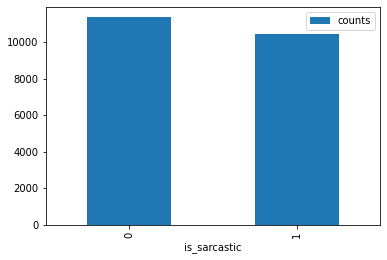

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#Seperate labels and display balance
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
counts_df = pd.DataFrame(df.groupby('is_sarcastic').size().reset_index(name='counts'))
counts_df.plot.bar(x='is_sarcastic', y='counts')

Die Zählung der Elemente aus dem Datensatz ergab einen geringen Überschuss an nicht sarkastischen Daten. Es ist aber auch eine Balance zu sehen, daher können die Daten ohne weitere Maßnahmen zum Trainieren verwendet werden.

### Wordcloud

Für einen Überblick über die Daten und ihren Inhalt lässt sich eine Wordcloud verwenden. Sie beschreibt die am häufigsten vorkommenden Worte in den gegebenen Texten. Im Folgenden wird unterschieden zwischen sarkastischen Texten und nicht sarkastischen Texten. 

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

In [ ]:
# Einlesen der Daten und Zusammenführung von Headlines unterschieden in sarkasitischen und nicht sarkasitischen 
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
df_is_sarcastic = df['is_sarcastic'] == 1
df_is_not_sarcastic = df['is_sarcastic'] == 0
df_sarcastic = df[df_is_sarcastic]
df_not_sarcastic = df[df_is_not_sarcastic]
headlines_sarcastic = df_sarcastic['headline'].values
headlines_not_sarcastic = df_not_sarcastic['headline'].values
text_not_sarcastic = "".join(headlines_not_sarcastic)
text_sarcastic = "".join(headlines_sarcastic)
# Initialisierung von Stopwords
stopwords_list = stopwords.words('english')
STOPWORDS.update(stopwords_list)
# Wordclouds erstellen
wordcloud_not_sarcastic = WordCloud(background_color="white").generate(text_not_sarcastic)
wordcloud_sarcastic = WordCloud(background_color="white").generate(text_sarcastic)
#Ausgabe
print("Wordcloud für die sarkastischen Headlines:")
plt.imshow(wordcloud_sarcastic, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Wordcloud für die nicht sarkastischen Headlines:")
plt.imshow(wordcloud_not_sarcastic, interpolation="bilinear")
plt.axis("off")
plt.show()

### Wort- und Textlänge

TODO

In [ ]:
# Clean texts to lowercase without punctuation
def clean_and_split(text):
    #convert to lowercase
    text = text.lower()
    #delete punctuation
    cleaned = text.translate(str.maketrans("", "", string.punctuation))
    return cleaned.split()

In [ ]:
def count_word_length(words):
    word_length_occ = [0] * 25
    for word in words:
        if len(word_length_occ) > len(word):
          word_length_occ[len(word)] += 1
        else:
          word_length_occ[len(word_length_occ) - 1] += 1
    return word_length_occ

[0, 2486, 13852, 16938, 17745, 16675, 13588, 11281, 7599, 4845, 3046, 1728, 940, 519, 325, 167, 95, 59, 42, 30, 8, 11, 5, 6, 5]
[0, 904, 14810, 13427, 18330, 15982, 13015, 12147, 8363, 5702, 3766, 1889, 1197, 618, 312, 138, 77, 33, 22, 19, 12, 8, 9, 2, 12]
9.85
10.62


ZeroDivisionError: ignored

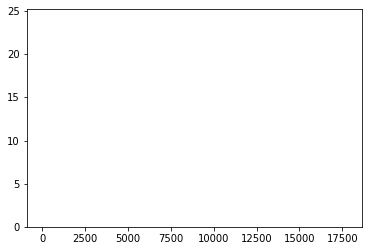

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
count_1_headline = []
count_0_headline = []
count_0_context = []
count_1_context = []
wl_occ_0_headline = [0] * 25
wl_occ_1_headline = [0] * 25
for index, row in df.iterrows():
  headline_tokens = clean_and_split(row['headline'])
  context_tokens = clean_and_split(row['context'])
  word_length_occ_headline = count_word_length(headline_tokens)
  word_length_occ_context = count_word_length(context_tokens)
  if row['is_sarcastic'] == 1:
    count_1_headline.append(len(headline_tokens))
    #count_1_context.append(len(context_tokens))
    for i in range(len(word_length_occ_headline)):
      wl_occ_1_headline[i] += word_length_occ_headline[i]
  else:
    count_0_headline.append(len(headline_tokens))
    #count_0_context.append(len(context_tokens))
    for i in range(len(word_length_occ_headline)):
      wl_occ_0_headline[i] += word_length_occ_headline[i]
print(wl_occ_0_headline)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], wl_occ_0_headline)
print(wl_occ_1_headline)
print(round(sum(count_0_headline) / len(count_0_headline), 2))
print(round(sum(count_1_headline) / len(count_1_headline), 2))
print(round(sum(count_1_context) / len(count_1_context), 2))
print(round(sum(count_0_context) / len(count_0_context), 2))

<BarContainer object of 25 artists>

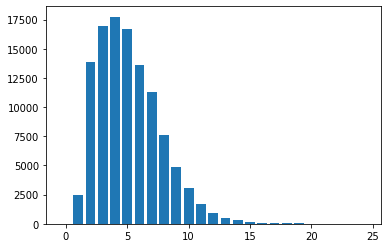

In [ ]:
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], wl_occ_0_headline)

<BarContainer object of 25 artists>

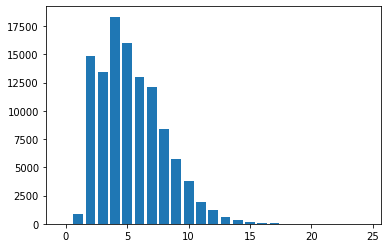

In [ ]:
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], wl_occ_1_headline)

Ein weiteres Feature in NLP, das zur Analyse eines Textes verwendet werden kann, ist die Anzahl der Worte, also die Länge des Textes. Im hier analysierten Fall der Sarkasmuserkennung von Artikelüberschriften wurde dieses Feature nicht verwendet.
In den meisten Fällen sind hier die sarkastischen Artikel viel kürzer als die nicht sarkastischen. Das kann auch mit der Datenquelle zusammenhängen, d.h. das Portal *theOnion.com* schreibt generell kürzere Artikel, die sarkastisch sind, während auf anderen Seiten sarkastische Texte auch länger sein können. Das Portal *huffingtonpost.com* schreibt hingegen längere Artikel, während andere seriöse Nachrichtenseiten kürzere Artikel schreiben könnten.

Die Überschriften, sowohl zu sarkastischen als auch nicht sarkastischen Texten, in diesem Datensatz sind etwa gleich lang. Da dieses Projekt darauf abzielt, anhand von Überschriften Sarkasmus zu erkennen und der Artikelinhalt nur als Einordnung und Kontext analysiert wird, wird die Textlänge als Feature nicht weiter berücksichtigt, da eine Korrelation zwischen Sarkasmus und der Anzahl der Worte in einer Überschrift als unwahrscheinlich eingestuft wird.

##Sentimentanalyse


In der Sentimentanalyse werden die Texte auf Polarität (polarity) geprüft, wobei diese einem Wert zwischen -1 und +1 zugeordnet wird. -1 steht dabei für sehr negativ und +1 für sehr positiv. Außerdem wird die Subjektivität (subjectivity) auf einer Skala von 0 bis 1 bestimmt. 1 ist dabei sehr subjektiv und 0 sehr objektiv.

In [ ]:
# Import for sentiment analysis
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
from textblob import TextBlob
import pandas as pd
import csv
import json

###Sentimentanalyse von Headline und Context

Hier wird das Sentiment der Headline und des Contextes der Artikel bestimmt und als Feature gespeichert. Zusätzlich wird der Zusammenhang mit dem Sarkasmus-Lable analysiert.
Headline und Context werden zusammen betrachtet, da eine erste Betrachtung gezeigt hat, dass die Headline alleine oft als neutral aus der Analyse hervor geht und mit 

In [ ]:
f_csv = open('/content/drive/My Drive/Colab Notebooks/sentiments.csv', 'w')
with f_csv:
    #prepare csv summary analysis
    fnames = ['is_sarcastic', 'polarity', 'subjectivity']
    csv_writer = csv.DictWriter(f_csv, fieldnames=fnames)    
    csv_writer.writeheader()
    #read dataframe
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_1.csv', sep=",")
    #insert new column for polarity
    df.insert( len(df.columns), "polarity", 0.0, True) 
    #insert new column for subjectivity
    df.insert( len(df.columns), "subjectivity", 0.0, True) 
    #process each row
    for index, row in df.iterrows():
        entry = {}
        #concat headline and context for analysis
        text = row['headline'] + "\n" + row['context']
        #get sentiment blob
        blob = TextBlob(text)
        #write entry for summary
        entry['is_sarcastic'] = row['is_sarcastic']
        entry['polarity'] = blob.sentiment[0]
        entry['subjectivity'] = blob.sentiment[1]
        csv_writer.writerow(entry)
        #write features to dataframe
        df.at[index,'polarity'] = blob.sentiment[0]
        df.at[index,'subjectivity'] = blob.sentiment[1]
    #save dataframe
    f_csv = open('/content/test_data_1.csv', 'w')
    f_json = open('/content/test_data_1.json', 'w')
    with f_csv and f_json:
        df.to_csv(f_csv, index=False)
        json_data = df.to_json(orient="index")
        json.dump(json_data, f_json)

Im Folgendem werden die Ergebnisse in Diagrammen dargestellt, um mögliche Zusammenhänge zu verdeutlichen.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sentiments.csv', sep=",")

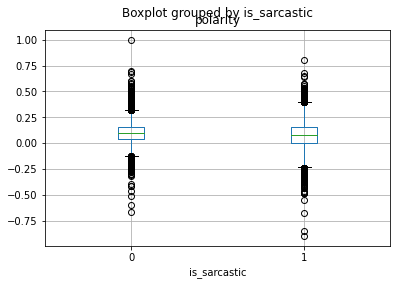

In [ ]:
df.boxplot('polarity', 'is_sarcastic')

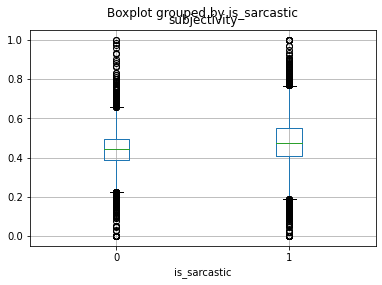

In [ ]:
df.boxplot('subjectivity', 'is_sarcastic')

In [ ]:
df.tail()

,is_sarcastic,polarity,subjectivity
21794,1,-0.152727,0.644242
21795,0,0.157320,0.498449
21796,1,0.067929,0.258838
21797,1,-0.072917,0.554167
21798,0,0.264030,0.405273


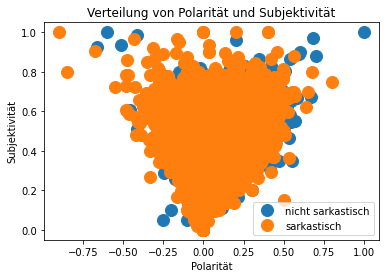

In [ ]:
import matplotlib.pyplot as plt

groups = df.groupby('is_sarcastic')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 0:
      titel = "nicht sarkastisch"
    else:
      titel = "sarkastisch"
    ax.plot(group['polarity'], group['subjectivity'], marker='o', linestyle='', ms=12, label=titel)
ax.set_xlabel("Polarität")
ax.set_ylabel("Subjektivität")
ax.set_title("Verteilung von Polarität und Subjektivität")
ax.legend()
plt.show()

##Emotionenanalyse

Emotionen werden mit Hilfe einer [Emotionen Liste](https://github.com/attreyabhatt/Sentiment-Analysis/blob/master/emotions.txt) gefunden, die bestimmten Schlagwörtern eine Emotion zuschreibt.

Auch hier liegt die Annahme zu Grunde, dass sarkastische Texte stärker emotionalisiert sind als nicht sarkastische. 


In [ ]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

In [ ]:
# Read data and split context, headlines and labels
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
# Extract emotions and tags from file
emotion_tags = []
emotion_set = set()
with open('/content/drive/My Drive/Colab Notebooks/emotions.txt') as file: 
  for line in file:
    clear_line = line.replace("\n", "").replace("'", "").replace(",", "").strip()
    word, emotion = clear_line.split(": ")
    emotion_tags.append([word, emotion])
    emotion_set.add(emotion)

In [ ]:
# Counts the different emotions from the given list
def count_occurences(emotion_list): 
  emotion_occ_list = []
  for emotion in emotion_list:
    #look for emotion in the occ_list and append if not in there
    i = 0
    found = False
    while (i < len(emotion_occ_list) and not found):
      if emotion == emotion_occ_list[i][0]:
        emotion_tuple = list(emotion_occ_list[i])
        emotion_tuple[1] += 1
        emotion_occ_list[i] = tuple(emotion_tuple)
        found = True
      i += 1
    if not found:
      emotion_occ_list.append((emotion, 1))
  return emotion_occ_list

In [ ]:
emotion_counter = []
stopwords_list = stopwords.words('english')
#insert new column for polarity
#df.insert( len(df.columns), "emotions", 0, True) 
#df['emotions'] = np.empty((len(df), 0)).tolist()
df['emotions'] =[[('emotion', 0)] for _ in range(len(df))]
#iterate rows and get emotions
for index, row in df.iterrows():
    headline = row['headline']
    context = row['context']
    #convert to lowercase
    context = context.lower()
    headline = headline.lower()
    #delete punctuation and tokenize
    cleaned_headline = headline.translate(str.maketrans("", "", string.punctuation))
    tokenized_headline = cleaned_headline.split()
    cleaned_context = context.translate(str.maketrans("", "", string.punctuation))
    tokenized_context = cleaned_context.split()
    #delete stopwords
    tokens = []
    for token in tokenized_headline:
      if token not in stopwords_list:
        tokens.append(token) 
    for token in tokenized_context:
      if token not in stopwords_list:
        tokens.append(token)      
    #search for emotions in tokens
    text_emotions = []
    for token in tokens:
      for emotion in emotion_tags:
        if emotion[0] == token:
          text_emotions.append(emotion[1])
    emotions_occ = count_occurences(text_emotions)
    df.at[index,'emotions'] = emotions_occ
    emotion_counter.append(emotions_occ) #occ list of emotions in one text

In [ ]:
import json
#save dataframe
f_csv = open('/content/data_1.csv', 'w')
f_json = open('/content/data_1.json', 'w')
with f_csv and f_json:
    df.to_csv(f_csv, index=False)
    json_data = df.to_json(orient="index")
    json.dump(json_data, f_json)

In [ ]:
# Split emotions into sarcastic and not sarcastic
sarcasm = df["is_sarcastic"].tolist()
key_data = {}
key_data_sarc = {}
for i in range (len(emotion_counter)):
  if len(emotion_counter[i]) > 0:
    if sarcasm[i] == 0 : #sarcastic 
      for j in range(len(emotion_counter[i])):
        if emotion_counter[i][j][0] in key_data:
          key_data[emotion_counter[i][j][0]] += emotion_counter[i][j][1] 
        else:
          #new
          key_data[emotion_counter[i][j][0]] = emotion_counter[i][j][1]
    else: #not sarcastic
      for j in range(len(emotion_counter[i])):
        if emotion_counter[i][j][0] in key_data_sarc:
          key_data_sarc[emotion_counter[i][j][0]] += emotion_counter[i][j][1] 
        else:
          #new
          key_data_sarc[emotion_counter[i][j][0]] = emotion_counter[i][j][1]

In [ ]:
def printEmotionOcc(data):
  sorteditems = sorted(data.items())
  keys = []
  vals = []
  for key,val in sorteditems:
    keys.append(key)
    vals.append(val)

  plt.bar(keys, vals)
  plt.xticks(rotation=90)
  plt.show()

**Emotionen in nicht sarkastischen Artikeln:**



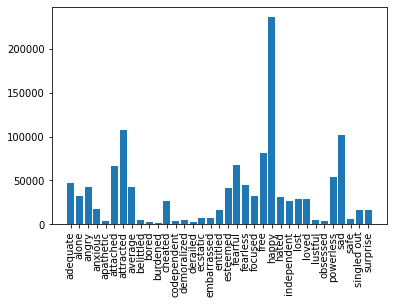

In [ ]:
printEmotionOcc(key_data)

**Emotionen in sarkastischen Artikeln:**

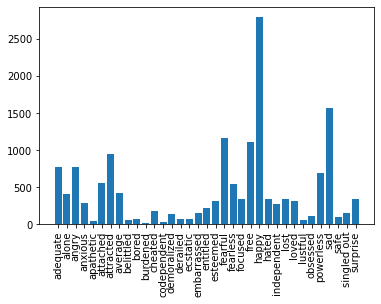

In [ ]:
printEmotionOcc(key_data_sarc)


**Wie werden Ergebnisse der Emotionsanalyse verwendet?**

Anhand der Grafiken lässt sich erkennen, dass die Emotionen sowohl in sarkastischen als auch nicht sarkastischen Texten ähnlich verteilt sind. Allerdings unterscheidet sich die Anzahl der Emotionen stark. Das liegt vor allem daran, dass sarkastische Artikel eher kürzer sind als nicht sarkastische. Die Länge des Textes soll aber nicht zur Klassifikation von Sarkasmus verwendet werden, da der Fokus dieses Projektes darauf liegt, Sarkasmus anhand einer Überschrift zu erkennen.

Sowohl in nicht sarkastischen als auch sarkastischen Artikeln und Überschriften finden sich zudem allgemein sehr wenig Emotionsschlagworte. Daher werden die Emotionen aus Überschrift und Artikel zusammen betrachtet. 

Aufgrund der wenigen Vorkommnisse von Emotionen, haben wir uns dazu entschieden, auch die Anzahl der Emotionen nicht zu berüchsichtigen, sondern als Feature nur aufzunehmen, welche Emotionen es gibt.

##Slanganalyse

In sarkastischen Texten wird möglicherweise häufiger Umgangssprache/Slang verwendet, als in nicht sarkastischen Texten. Allerdings liegt auch die Vermutung nahe, dass dies in den Artikelüberschriften aufgrund der Kürze wenig bis gar kein Slang zu finden ist.

Da es keine frei verfügbare Slang-Library gibt, die herausfinden kann, ob ein Text in Slang geschrieben wurde oder nicht, muss dies anhand bestimmter, selbst gewählter Eigenschaften herausgefunden werden.

Im Folgenden wird untersucht, ob ein Text profan ist oder nicht. Dafür wurde die Library [*profanity-check*](https://pypi.org/project/profanity-check/) verwendet, damit dennoch herausgefunden werden kann, ob ein Text anstößige Worte enthält oder nicht. 

Die verwendete Library nutzt nicht nur ein Dictionary zum Finden bestimmter Wörter, sondern eine SVM.


In [ ]:
!pip install profanity-check
from profanity_check import predict, predict_prob
import pandas as pd
import csv

In [ ]:
def isOffensive(text):
  probs = predict_prob([text])
  return probs[0]

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data_1.csv', sep=",")
offenses = []
for i, row in df.iterrows():
    h_offense = isOffensive(df['headline'][i])
    c_offense = isOffensive(df['context'][i])
    offenses.append(dict(is_sarcastic=df['is_sarcastic'][i], headline_offense=h_offense, context_offense=c_offense))
    df.loc[index,'headline_offense'] = float(headline_offense)
    df.loc[index,'context_offense'] = float(context_offense)

In [ ]:
df.head()

,is_sarcastic,headline,article_link,context,emotions,polarity,subjectivity,headline_offense,context_offense
0,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,"""We are neither post-racial nor post-gender,"" ...","[('lost', 9), ('hated', 18), ('attached', 9)]",0.120306,0.442796,NaN,NaN
1,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,"PROVIDENCE, RI—In spite of his best efforts to...","[('fearless', 1)]",0.152333,0.456000,NaN,NaN
2,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,"PATERSON, NJ—Family sources told reporters Tue...","[('surprise', 1)]",0.206723,0.503221,NaN,NaN
3,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,To what extent do you own your inheritance? L...,"[('loved', 21), ('free', 21)]",0.110224,0.365159,NaN,NaN
4,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...,LONDON—Analysts are predicting that the $3 bil...,[],0.020000,0.320000,NaN,NaN


In [ ]:
#save dataframe
f_csv = open('/content/data_1.csv', 'w')
with f_csv and f_json:
    df.to_csv(f_csv, index=False)

In [ ]:
f_csv = open('/content/drive/My Drive/offenses.csv', 'w')

with f_csv:
    #prepare csv summary analysis
    fnames = ['is_sarcastic', 'headline_offense', 'context_offense']
    csv_writer = csv.DictWriter(f_csv, fieldnames=fnames)    
    csv_writer.writeheader()

    entry = {}
    
    for element in offenses:
      entry['is_sarcastic'] = element['is_sarcastic']
      entry['headline_offense'] = element['headline_offense']
      entry['context_offense'] = element['context_offense']
      csv_writer.writerow(entry)

# Neuronales Netz zur Klassifizierung von Sarkasmus

Als Deep Learning Framework wurde Keras ausgesucht.

Beim Bau unseres Models haben wir uns an das allgemeine Vorgehen gehalten, für die Hidden Layers eine ReLu-Funktion (rectified linear unit) als Aktivierungsfunktion zu nutzen und eine Sigmoidfunktion für den Output Layer, da es sich bei unserem Problem um eine binäre Klassifikation (sarkastisch oer nicht sarkastisch) handelt.

Keras bietet verschiedene Optimierungsfunktionen:

*   Adam
*   Nadam
*   Adamax



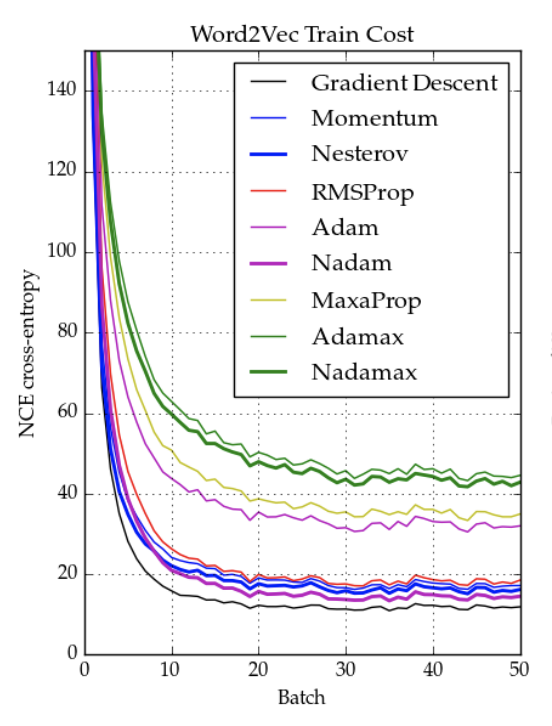

Quelle: https://paperswithcode.com/method/nadam# (12.09.2020)

Adamax hat in verschiedenen Tests die höchste Accuracy geliefert.

Verschiedene Techniken zur Vektorisierung.

##NN mit Keras

https://realpython.com/python-keras-text-classification/

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data.csv', sep=",")
print(df.iloc[0])

FileNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
sentences = df['headline'].values
y = df['is_sarcastic'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

NameError: ignored

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<16349x21410 sparse matrix of type '<class 'numpy.int64'>'
	with 164468 stored elements in Compressed Sparse Row format>

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

NameError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8361467889908257


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
def buildModel(numNeurons,numHiddenLayer,  numEpochs):
  model = Sequential()
  i = 0; 
  for i in range(0, numHiddenLayer):
    model.add(layers.Dense(numNeurons, input_dim=input_dim, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  history = model.fit(X_train, y_train, epochs=numEpochs, verbose=False, validation_data=(X_test, y_test), batch_size=10)
  loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  plot_history(history)

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=50, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                214110    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9996
Testing Accuracy:  0.7916


KeyError: ignored

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=60, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                214110    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9998
Testing Accuracy:  0.7943


KeyError: ignored

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=40, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                214110    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9998
Testing Accuracy:  0.7987


KeyError: ignored

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                214110    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9993
Testing Accuracy:  0.7956


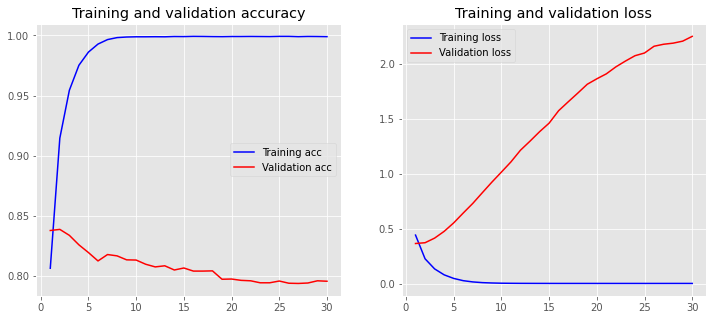

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=30, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                214110    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9923
Testing Accuracy:  0.8239


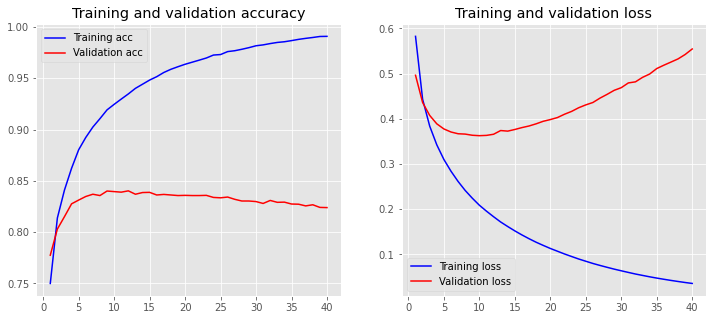

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=40, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                214110    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9513
Testing Accuracy:  0.8394


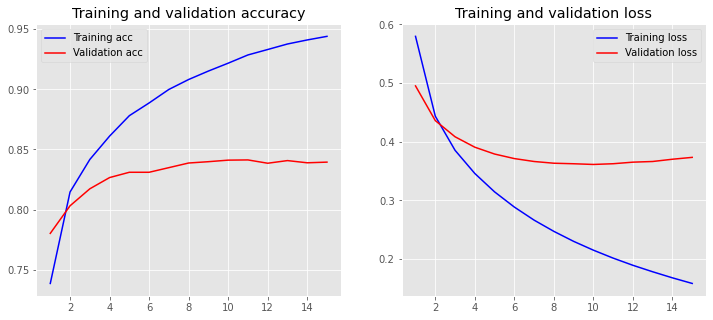

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=15, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                214110    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9950
Testing Accuracy:  0.8167


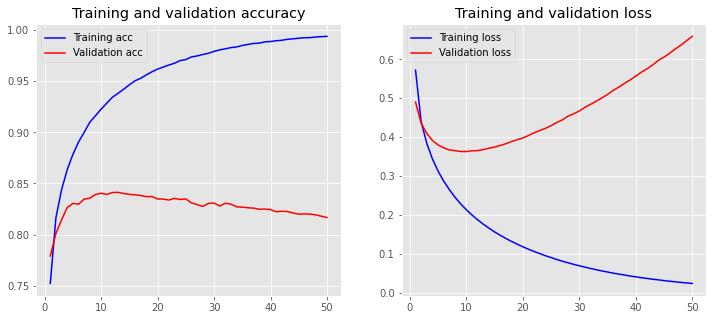

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs=50, verbose=False, validation_data=(X_test, y_test), batch_size=10, callbacks=[callback])
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=40, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                214110    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.7949


KeyError: ignored

In [ ]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 10)                214110    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 214,121
Trainable params: 214,121
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9995
Testing Accuracy:  0.7976


KeyError: ignored

## SVM

Support Vector Machines zur Klassifizierung des Datensets.

**Support Vector Maschines**

Neben einem Neuronalen Netz haben wir eine weitere Architektur genutzt, die Support Vector Machines. Diese beiden Ansätze sind sehr ähnlich. Trotzdem wollten wir herausfinden, ob die eine Architektur wesentlich besser ist als die andere. 

Folgende Parameter haben wir dafür angepasst:


*   Kernel (sigmoid, linear, rbf)
*   Grad des Polynoms
*   Regularization 








In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [ ]:
np.random.seed(500)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_1.csv', sep=",")
# remove blank rows
df['headline'].dropna(inplace=True)
# headlines to lower case + tokenization
for index, row in df.iterrows():
  df.at[index, 'headline'] = word_tokenize(row['headline'].lower())
# remove stop words and numeric values + word stemming/lemmenting
# tags to understand if the word is noun or verb or adjective
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df['headline']):
    cleaned_words = []
    lemmatizer = WordNetLemmatizer()
    for word, tag in pos_tag(entry): # tag word
        if word not in stopwords.words('english') and word.isalpha():
            cleaned_word = lemmatizer.lemmatize(word,tag_map[tag[0]])
            cleaned_words.append(cleaned_word)
    df.loc[index,'cleaned_headline'] = str(cleaned_words)

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['cleaned_headline'],df['is_sarcastic'],test_size=0.3)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['cleaned_headline'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

**SVM with linear kernel**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  87.33206632151517
SVM Test Accuracy Score ->  78.33333333333333


**SVM with sigmoid kernel**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='sigmoid', gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  77.99694189602447


**SVM with rbf kernel**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='rbf', gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  78.68501529051987


**SVM with polynomial kernel of second degree**

In [ ]:
SVM = svm.SVC(C=1.0, kernel='poly', degree=2, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  98.97765253293139
SVM Test Accuracy Score ->  78.92966360856269


**SVM with polynomial kernel of second degree with C=1.5**

In [ ]:
SVM = svm.SVC(C=1.5, kernel='poly', degree=2, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)


SVM Training Accuracy Score ->  99.55436136050855
SVM Test Accuracy Score ->  78.79204892966361


**SVM with polynomial kernel of second degree with C=0.5**

In [ ]:
SVM = svm.SVC(C=0.5, kernel='poly', degree=2, gamma='scale')
SVM.fit(Train_X_Tfidf,Train_Y)
# show accuracy of training set
predictions_SVM = SVM.predict(Train_X_Tfidf)
print("SVM Training Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)
# show accuracy of test set
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Test Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Training Accuracy Score ->  96.4873189593027
SVM Test Accuracy Score ->  77.64525993883792
